In [1]:
from typing import Callable, Iterator, Sequence
from sklearn.model_selection import train_test_split
import functools

import numpy as np
import scipy as sp
import matplotlib.pylab as plt

import jax.numpy as jnp
import jax.scipy as jsp
import jax
import flax.linen as nn
import optax
import haiku as hk
import chex
import tqdm
from scipy.stats import gaussian_kde

## Dataset

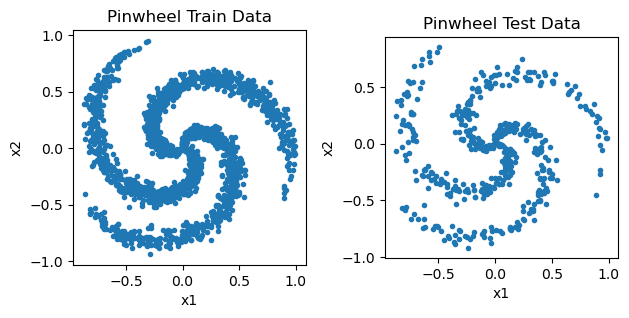

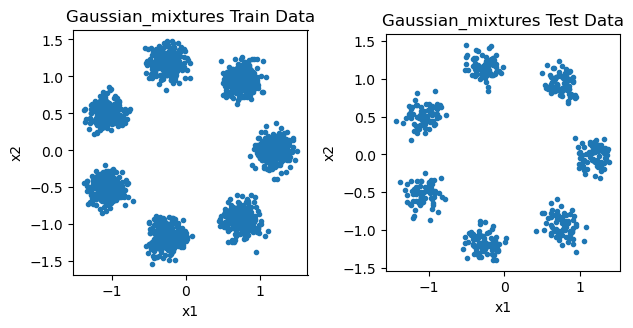

In [2]:
# X1 pinwheel, X2 gaussian_mixtures
X1_train, X1_test = np.load('Pinwheel_train.npy'), np.load('Pinwheel_test.npy')
X2_train, X2_test = np.load('Gaussian_Mixtures_train.npy'), np.load('Gaussian_Mixtures_test.npy')

fig1, ax1 = plt.subplots(1, 2)
ax1[0].plot(X1_train[:, 0], X1_train[:, 1], '.')
ax1[0].set_xlabel('x1')
ax1[0].set_ylabel('x2')
ax1[0].set_title('Pinwheel Train Data')
ax1[0].set_aspect('equal') 

ax1[1].plot(X1_test[:, 0], X1_test[:, 1], '.')
ax1[1].set_xlabel('x1')
ax1[1].set_ylabel('x2')
ax1[1].set_title('Pinwheel Test Data')
ax1[1].set_aspect('equal')

plt.tight_layout()
plt.savefig("pinwheel_600dpi.png", dpi=600) 
plt.show()

fig2, ax2 = plt.subplots(1, 2)
ax2[0].plot(X2_train[:, 0], X2_train[:, 1], '.')
ax2[0].set_xlabel('x1')
ax2[0].set_ylabel('x2')
ax2[0].set_title('Gaussian_mixtures Train Data')
ax2[0].set_aspect('equal') 

ax2[1].plot(X2_test[:, 0], X2_test[:, 1], '.')
ax2[1].set_xlabel('x1')
ax2[1].set_ylabel('x2')
ax2[1].set_title('Gaussian_mixtures Test Data')
ax2[1].set_aspect('equal')

plt.tight_layout()
plt.savefig("gaussian_mixtures_600dpi.png", dpi=600) 
plt.show()

np.save("Pinwheel_train.npy", X1_train)
np.save("Pinwheel_test.npy", X1_test)
np.save("Gaussian_Mixtures_train.npy", X2_train)
np.save("Gaussian_Mixtures_test.npy", X2_test)

## Define MLP score function

In [3]:
Activation = Callable[[jax.Array], jax.Array]

class MLP(nn.Module):
    
    features: Sequence[int]
    activation: Activation = nn.swish

    @nn.compact
    def __call__(self, x: jax.Array) -> jax.Array:
        for f in self.features[:-1]:
            x = nn.Dense(f)(x)
            x = self.activation(x)
        x = nn.Dense(self.features[-1])(x)
        return x

model = MLP(features=[64, 64, 2])
print(model.tabulate(jax.random.PRNGKey(0), np.zeros((1, 2))))


                                 MLP Summary                                 
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs        ┃ outputs       ┃ params                 ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float32[1,2]  │ float32[1,2]  │                        │
├─────────┼────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_0 │ Dense  │ float32[1,2]  │ float32[1,64] │ bias: float32[64]      │
│         │        │               │               │ kernel: float32[2,64]  │
│         │        │               │               │                        │
│         │        │               │               │ 192 (768 B)            │
├─────────┼────────┼───────────────┼───────────────┼────────────────────────┤
│ Dense_1 │ Dense  │ float32[1,64] │ float32[1,64] │ bias: float32[64]      │
│         │        │               │               │ kernel: fl

## Loss Function

In [4]:
# DSM loss function
def dsm_loss(
    params: chex.ArrayTree,
    x: jax.Array,
    sigma: float,
    k: int,
    key: chex.PRNGKey    
) -> float:
    """
    Computes the DSM loss.

    Args:
    - params: Model parameters.
    - model: A function representing the model.
    - x: The input data batch.
    - sigma: Noise standard deviation.
    - key: PRNG key for generating noise.
    - k: Number of noise realizations.

    Returns:
    - loss: The DSM loss.
    """
    n = x.shape[0]  # Batch size

    # Generate k noise realizations for each input
    noise = jax.random.normal(key, shape=(n, k, x.shape[1]))  # Shape (n, k, dim)
    x_tilde = x[:, None, :] + sigma * noise  # Add noise to inputs (n, k, dim)
    
    # Flatten the noisy samples for batch processing
    x_tilde_flat = x_tilde.reshape(-1, x.shape[1])  # Shape (n * k, dim)
    
    # Apply the model to noisy samples
    f_x_tilde = jax.vmap(lambda xi: model.apply(params, xi))(x_tilde_flat)
    f_x_tilde = f_x_tilde.reshape(n, k, -1)  # Reshape to (n, k, dim)

    # Compute the DSM loss
    residual = x_tilde + sigma**2 * f_x_tilde - x[:, None, :]  # Shape (n, k, dim)
    loss = jnp.sum(jnp.linalg.norm(residual, axis=-1) ** 2) / k 

    return loss

## Training Model

In [5]:
@functools.partial(jax.jit, static_argnums=(3, 4))
def do_batch_update(
    batch: jax.Array,
    params: chex.ArrayTree, 
    opt_state: optax.OptState,
    sigma: float,
    k: int,
    key: chex.PRNGKey
) -> tuple[float, chex.ArrayTree, optax.OptState, chex.PRNGKey]:

    key, subkey = jax.random.split(key)
    
    loss, grad = jax.value_and_grad(dsm_loss, argnums=0)(params, batch, sigma, k, subkey)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state, key 

class BatchManager(Iterator[np.ndarray]):
    
    def __init__(
        self,
        data: np.ndarray,
        batch_size: int,
        key: chex.PRNGKey
    ):
        batch_size = min(batch_size, len(data))
        self._num_batches = len(data) // batch_size
        self._batch_idx = None
        self._batch_size = batch_size
        self._key = key
        self._data = data
        self._reset()

    @property
    def num_batches(self) -> int:
        return self._num_batches

    def _reset(self) -> None:
        self._key, subkey = jax.random.split(self._key)
        self._perm = jax.random.permutation(subkey, len(self._data))
        self._batch_idx = 0

    def __next__(self) -> np.ndarray:
        assert self._batch_idx is not None
        assert self._batch_idx >= 0 and self._batch_idx < self._num_batches
        inds = self._perm[self._batch_idx * self._batch_size : (self._batch_idx + 1) * self._batch_size]
        batch = self._data[inds]
        self._batch_idx += 1
        if self._batch_idx >= self._num_batches:
            self._reset()
        return batch

## Testing Model

In [6]:
def evaluate_test_loss(params, test_data, sigma, k, key):
    # Assuming test_data is already preprocessed
    loss, _ = jax.value_and_grad(dsm_loss, argnums=0)(params, test_data, sigma, k, key)
    return loss

## Results for Pinwheel

In [7]:
optimizer = optax.adam(learning_rate=1e-3)
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))

mean1, mean2 = np.mean(X1_train, axis=0), np.mean(X1_test, axis=0)
std1, std2 = np.std(X1_train, axis=0), np.std(X1_test, axis=0)
X1_train = (X1_train - mean1) / std1
X1_test =  (X1_test - mean2) / std2


params = model.init(next(prng_seq), X1_train[:1, ...])
opt_state = optimizer.init(params)
bm = BatchManager(data=X1_train, batch_size=128, key=next(prng_seq))

sigma, k, key = 0.1, 20, jax.random.PRNGKey(0)

losses = []
test_losses = []
for _ in tqdm.tqdm(range(20000)):
    batch = next(bm)
    loss, params, opt_state, key = do_batch_update(batch, params, opt_state, sigma = sigma, k = k, key = key)
    test_loss = evaluate_test_loss(params, X1_test, sigma, k, key)
    losses.append(loss)
    test_losses.append(test_loss)
    
losses = np.array(losses)
test_losses = np.array(test_losses)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:50<00:00, 30.75it/s]


In [8]:
def compute_ema(losses, alpha=0.01):
    ema_losses = [losses[0]]  
    for loss in losses[1:]:
        ema_current = alpha * loss + (1 - alpha) * ema_losses[-1]  
        ema_losses.append(ema_current)
    return np.array(ema_losses)

ema_losses = compute_ema(losses)
ema_test_losses = compute_ema(test_losses)

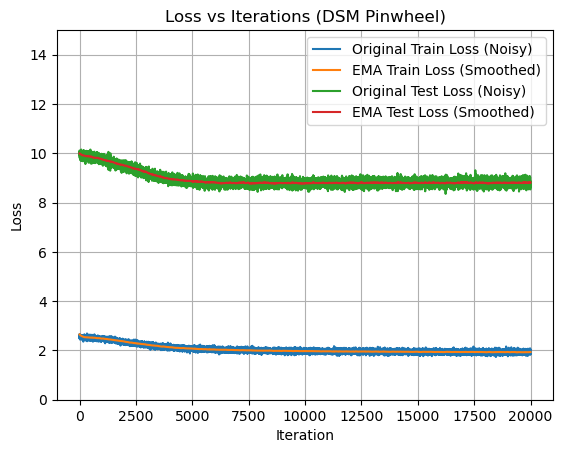

In [9]:
# Plot the original and EMA train loss curves
plt.plot(losses, label="Original Train Loss (Noisy)")  # Original noisy loss curve
plt.plot(ema_losses, label="EMA Train Loss (Smoothed)")  # Smoothed EMA curve
# Plot the original and EMA test loss curves
plt.plot(test_losses, label="Original Test Loss (Noisy)")  # Original noisy loss curve
plt.plot(ema_test_losses, label="EMA Test Loss (Smoothed)")  # Smoothed EMA curve

# Add labels, title, and legend
plt.xlabel("Iteration")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Loss vs Iterations (DSM Pinwheel)")  # Title of the plot
plt.legend(loc='upper right')  # Show the legend
plt.grid(True)  # Add a grid for better visualization

plt.ylim(0, 15)

plt.savefig("DSM_Loss_epoch_pinwheel.png", dpi=600) 

# Display the plot
plt.show()

In [10]:
@functools.partial(jax.jit, static_argnames=("num_steps",))
def langevin_sampling(
    params: chex.ArrayTree,
    key: chex.PRNGKey,
    step_size: float,
    initial_samples: jax.Array,
    num_steps: int,
) -> jax.Array:

    def scan_fn(carry, _):
        states, key = carry
        key, sk = jax.random.split(key)
        noise = jax.random.normal(sk, shape=states.shape)
        next_states = states + step_size * model.apply(params, states) + jnp.sqrt(2 * step_size) * noise
        return (next_states, key), None

    states = initial_samples
    (states, _), _ = jax.lax.scan(scan_fn, (states, key), jnp.arange(num_steps))
    return states

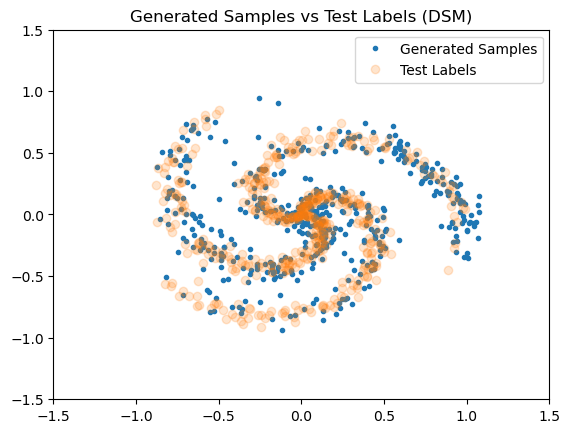

In [11]:
samples = langevin_sampling(
    params,
    next(prng_seq),
    5e-3,
    2 * jax.random.normal(next(prng_seq), shape=(500, 2)),
    1000)

samples = samples * std1 + mean1
X1_test = X1_test * std2 + mean2
plt.plot(samples[:, 0], samples[:, 1], '.', label="Generated Samples")
plt.plot(X1_test[:, 0], X1_test[:, 1], 'o', alpha=0.2, label="Test Labels")

plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.title("Generated Samples vs Test Labels (DSM)")
plt.legend()
plt.savefig("DSM_samples_pinwheel.png", dpi=600) 
plt.show()

In [12]:
kde_generated = gaussian_kde(samples.T)
kde_real = gaussian_kde(X1_test.T)
log_likelihood_of_real_on_generated = kde_generated.logpdf(X1_test.T)
log_likelihood_of_generated_on_real = kde_real.logpdf(samples.T)
print('Sum of log-likelihood of generated data under the real data distribution:', np.sum(log_likelihood_of_real_on_generated))
print('Mean of log-likelihood of generated data under the real data distribution:', np.mean(log_likelihood_of_real_on_generated))
print('Sum of log-likelihood of generated data under the real data distribution:', np.sum(log_likelihood_of_generated_on_real))
print('Mean of log-likelihood of generated data under the real data distribution:', np.mean(log_likelihood_of_generated_on_real))

Sum of log-likelihood of generated data under the real data distribution: -436.9418481525996
Mean of log-likelihood of generated data under the real data distribution: -0.8738836963051992
Sum of log-likelihood of generated data under the real data distribution: -469.64732077708044
Mean of log-likelihood of generated data under the real data distribution: -0.9392946415541609


## Results for Gaussian Mixtures

In [13]:
optimizer = optax.adam(learning_rate=1e-3)
prng_seq = hk.PRNGSequence(jax.random.PRNGKey(0))

mean1, mean2 = np.mean(X2_train, axis=0), np.mean(X2_test, axis=0)
std1, std2 = np.std(X2_train, axis=0), np.std(X2_test, axis=0)
X2_train = (X2_train - mean1) / std1
X2_test =  (X2_test - mean2) / std2


params = model.init(next(prng_seq), X2_train[:1, ...])
opt_state = optimizer.init(params)
bm = BatchManager(data=X2_train, batch_size=128, key=next(prng_seq))

sigma, k, key = 0.1, 20, jax.random.PRNGKey(0)

losses = []
test_losses = []
for _ in tqdm.tqdm(range(20000)):
    batch = next(bm)
    loss, params, opt_state, key = do_batch_update(batch, params, opt_state, sigma = sigma, k = k, key = key)
    test_loss = evaluate_test_loss(params, X2_test, sigma, k, key)
    losses.append(loss)
    test_losses.append(test_loss)
    
losses = np.array(losses)
test_losses = np.array(test_losses)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:05<00:00, 33.02it/s]


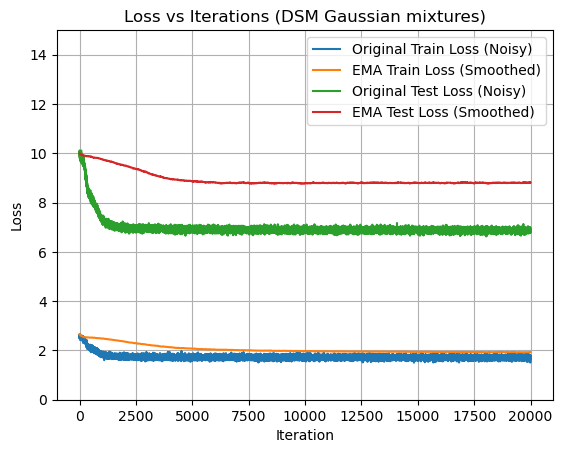

In [14]:
# Plot the original and EMA train loss curves
plt.plot(losses, label="Original Train Loss (Noisy)")  # Original noisy loss curve
plt.plot(ema_losses, label="EMA Train Loss (Smoothed)")  # Smoothed EMA curve
# Plot the original and EMA test loss curves
plt.plot(test_losses, label="Original Test Loss (Noisy)")  # Original noisy loss curve
plt.plot(ema_test_losses, label="EMA Test Loss (Smoothed)")  # Smoothed EMA curve

# Add labels, title, and legend
plt.xlabel("Iteration")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.title("Loss vs Iterations (DSM Gaussian mixtures)")  # Title of the plot
plt.legend(loc='upper right')  # Show the legend
plt.grid(True)  # Add a grid for better visualization

plt.ylim(0, 15)

plt.savefig("DSM_Loss_epoch_gaussian_mixtures.png", dpi=600) 

# Display the plot
plt.show()

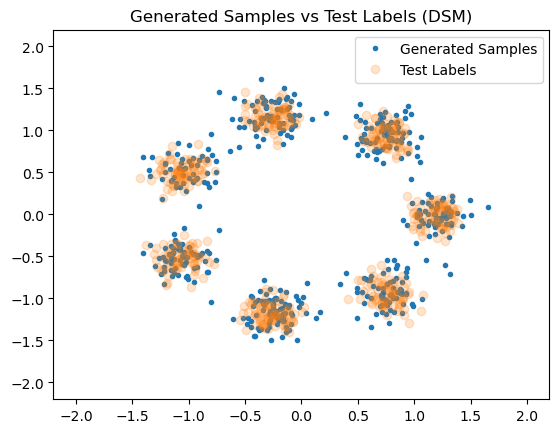

In [15]:
samples = langevin_sampling(
    params,
    next(prng_seq),
    5e-3,
    2 * jax.random.normal(next(prng_seq), shape=(500, 2)),
    1000)
samples = samples * std1 + mean1
X2_test = X2_test * std2 + mean2
plt.plot(samples[:, 0], samples[:, 1], '.', label="Generated Samples")
plt.plot(X2_test[:, 0], X2_test[:, 1], 'o', alpha=0.2, label="Test Labels")

plt.xlim([-2.2, 2.2])
plt.ylim([-2.2, 2.2])
plt.title("Generated Samples vs Test Labels (DSM)")
plt.legend()
plt.savefig("DSM_samples_gaussian_mixtures.png", dpi=600) 
plt.show()

In [16]:
kde_generated = gaussian_kde(samples.T)
kde_real = gaussian_kde(X2_test.T)
log_likelihood_of_real_on_generated = kde_generated.logpdf(X2_test.T)
log_likelihood_of_generated_on_real = kde_real.logpdf(samples.T)
print('Sum of log-likelihood of generated data under the real data distribution:', np.sum(log_likelihood_of_real_on_generated))
print('Mean of log-likelihood of generated data under the real data distribution:', np.mean(log_likelihood_of_real_on_generated))
print('Sum of log-likelihood of generated data under the real data distribution:', np.sum(log_likelihood_of_generated_on_real))
print('Mean of log-likelihood of generated data under the real data distribution:', np.mean(log_likelihood_of_generated_on_real))

Sum of log-likelihood of generated data under the real data distribution: -868.3569274054491
Mean of log-likelihood of generated data under the real data distribution: -1.7367138548108982
Sum of log-likelihood of generated data under the real data distribution: -870.7885745624579
Mean of log-likelihood of generated data under the real data distribution: -1.741577149124916
